Para trabajar en la solución de problemas primero importamos la libreria de `pandas` para poder guardar los datos en la variable `data` de la base de datos.

In [89]:
import pandas as pd
data = pd.read_csv("Calificaciones.csv")
print(data.dtypes)
print(data.head())

Escuela           object
Sexo              object
Edad               int64
HorasDeEstudio     int64
Reprobadas         int64
Internet          object
Faltas             int64
G1                 int64
G2                 int64
G3                 int64
dtype: object
  Escuela Sexo  Edad  HorasDeEstudio  Reprobadas Internet  Faltas  G1  G2  G3
0      GP    F    18               2           0       no       6   5   6   6
1      GP    F    17               2           0      yes       4   5   5   6
2      GP    F    15               2           3      yes      10   7   8  10
3      GP    F    15               3           0      yes       2  15  14  15
4      GP    F    16               2           0       no       4   6  10  10


Existe un problema con este archivo: algunas variables son cualitativas. Para resolverlo, transformaremos dichas variables en cuantitativas. Primero, utilizaremos la función de pandas `get_dummies` junto con `concat` para crear variables binarias representadas con valores `True` y `False`. Después, convertiremos la variable de horas de estudio en sus respectivos niveles para que también pueda ser interpretada de manera booleana.

In [90]:
import numpy as np
ind=np.where(data.dtypes==object)
for i in ind:
      dummy=pd.get_dummies(data.iloc[:,i],drop_first=True)
      data=pd.concat([data,dummy],axis=1)
data=data.drop(labels=data.columns[ind],axis=1)
dummyHoras = pd.get_dummies(data.HorasDeEstudio,drop_first = True)
data=pd.concat([data,dummyHoras],axis=1)
data=data.drop("HorasDeEstudio",axis=1)
print(data.head())
print(data.shape)

   Edad  Reprobadas  Faltas  G1  G2  G3  Escuela_MS  Sexo_M  Internet_yes  \
0    18           0       6   5   6   6       False   False         False   
1    17           0       4   5   5   6       False   False          True   
2    15           3      10   7   8  10       False   False          True   
3    15           0       2  15  14  15       False   False          True   
4    16           0       4   6  10  10       False   False         False   

       2      3      4  
0   True  False  False  
1   True  False  False  
2   True  False  False  
3  False   True  False  
4   True  False  False  
(395, 12)


Para nuestro segundo problema, revisaremos si la variable **Faltas** contiene valores atípicos dentro de nuestros datos. Para ello utilizaremos el método de **Tukey**, el cual nos ayuda a identificar los valores que se encuentran fuera del rango típico.

In [91]:
q1=data.Faltas.quantile(0.25)
q3=data.Faltas.quantile(0.75)
iqr=q3-q1
li=q1-(3*iqr)
ls=q3+(3*iqr)
out=np.where((data.Faltas<=li) | (data.Faltas>=ls))[0]
print(data.iloc[out,:])
data = data.drop(index=out)
print("Estos valores atipicos se pudieran considerar errores en medicion, pues estos valores no coinciden con las otras variables de medicion. Por lo tanto, se eliminaran.")

     Edad  Reprobadas  Faltas  G1  G2  G3  Escuela_MS  Sexo_M  Internet_yes  \
74     16           0      54  11  12  11       False   False          True   
183    17           0      56   9   9   8       False   False          True   
276    18           0      75  10   9   9       False   False          True   
307    19           1      38   8   9   8       False    True          True   
315    19           1      40  13  11  11       False   False          True   

         2      3      4  
74    True  False  False  
183   True  False  False  
276   True  False  False  
307  False  False  False  
315  False   True  False  
Estos valores atipicos se pudieran considerar errores en medicion, pues estos valores no coinciden con las otras variables de medicion. Por lo tanto, se eliminaran.


Para nuestro tercer problema revisaremos si los datos presentan **colinealidad**. Para ello construiremos una **matriz de correlaciones** utilizando la librería `seaborn`.

En el código, primero se calcula la matriz de correlaciones absolutas y se busca el par de variables con la mayor relación. Posteriormente, se define un umbral de `0.9` para identificar correlaciones demasiado altas y, con base en su relación con la variable objetivo, se decide cuál de las dos variables eliminar.

Mayor correlación entre columnas: 4 y 5
Valor: 0.9047966735871248
Al ver la matriz de correlaciones, se puede observar que la columna 4 {'G2'} Tiene una correlacion bastante significante (0.9 y 0.85). Por esto la eliminaremos.


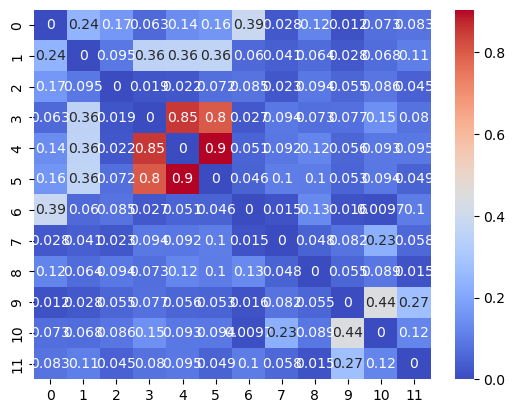

In [92]:
import numpy as np
from seaborn import heatmap

cor = data.corr().abs().values  
np.fill_diagonal(cor, 0)
# Obtener los índices (i,j) de la posición del valor máximo
i, j = np.unravel_index(cor.argmax(), cor.shape)

print("Mayor correlación entre columnas:", i, "y", j)
print("Valor:", cor[i, j])
heatmap(cor, annot=True, cmap="coolwarm")
y = data.G3

corr_matrix = data.corr().abs()
to_drop = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if corr_matrix.iloc[i, j] > 0.9:
            colname1 = corr_matrix.columns[i]
            colname2 = corr_matrix.columns[j]
            if abs(data[colname1].corr(y)) > abs(data[colname2].corr(y)):
                to_drop.add(colname2)
            else:
                to_drop.add(colname1)

print("Al ver la matriz de correlaciones, se puede observar que la columna 4", to_drop, "Tiene una correlacion bastante significante (0.9 y 0.85). Por esto la eliminaremos.")
data = data.drop(columns=to_drop)

Con el objetivo de descartar la problemática de posibles **interacciones** no consideradas en el modelo, generamos nuevas variables a partir del producto de algunas ya existentes. En este caso, creamos la variable `Escuela_Internet`, que combina la escuela a la que asiste el estudiante con el acceso a internet en casa, y la variable `Reprobadas_Faltas`, que relaciona la cantidad de materias reprobadas con las faltas acumuladas.

Finalmente, convertimos los valores booleanos (`True/False`) a enteros (`1/0`) para asegurar que todas las variables estén en un formato numérico y sean compatibles con el análisis.

In [93]:
data["Escuela_Internet"] = data["Escuela_MS"] * data["Internet_yes"]
data["Reprobadas_Faltas"] = data["Reprobadas"] * data["Faltas"]
data = data.applymap(lambda x: int(x) if isinstance(x, bool) else x)
print(data.head())

   Edad  Reprobadas  Faltas  G1  G3  Escuela_MS  Sexo_M  Internet_yes  2  3  \
0    18           0       6   5   6           0       0             0  1  0   
1    17           0       4   5   6           0       0             1  1  0   
2    15           3      10   7  10           0       0             1  1  0   
3    15           0       2  15  15           0       0             1  0  1   
4    16           0       4   6  10           0       0             0  1  0   

   4  Escuela_Internet  Reprobadas_Faltas  
0  0                 0                  0  
1  0                 0                  0  
2  0                 0                 30  
3  0                 0                  0  
4  0                 0                  0  


C:\Users\jesus\AppData\Local\Temp\ipykernel_30576\224433945.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x: int(x) if isinstance(x, bool) else x)


Ahora construiremos un `modelo de regresión lineal múltiple` con el objetivo de evaluar la calidad de nuestro modelo y analizar qué tan bien explican las variables independientes la variable objetivo G3.

En el código, se divide la base de datos en un conjunto de entrenamiento (**80%**) y otro de prueba (**20%**). Posteriormente, se entrena el modelo con las variables predictoras (X_train) y la variable dependiente (Y_train). Para ello se utiliza la librería `statsmodels` con la función `OLS`.

Al final, se imprime un resumen estadístico del modelo, donde se incluyen indicadores clave como los coeficientes, los valores p de cada variable, y el f-pvalue que evalúa la significancia global del modelo. Estos resultados nos permiten determinar tanto la calidad general del ajuste como la relevancia individual de las variables incluidas.

In [94]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
train, test = train_test_split(data, train_size = 0.8)
X_train = train.drop('G3', axis = 1)
X_test = test.drop('G3', axis = 1)
Y_train = train.G3
Y_test = test.G3

model = sm.OLS(Y_train,sm.add_constant(X_train))
results = model.fit()
print(results.summary())
print(results.pvalues)
print(results.f_pvalue)

                            OLS Regression Results                            
Dep. Variable:                     G3   R-squared:                       0.678
Model:                            OLS   Adj. R-squared:                  0.665
Method:                 Least Squares   F-statistic:                     52.46
Date:                Mon, 25 Aug 2025   Prob (F-statistic):           2.68e-66
Time:                        19:53:04   Log-Likelihood:                -748.49
No. Observations:                 312   AIC:                             1523.
Df Residuals:                     299   BIC:                             1572.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 6.6439      2.40

En este paso buscamos comprobar qué tan bueno es nuestro modelo al predecir con los datos de prueba. Para ello, generamos las predicciones (`Y_hatTest`) a partir del conjunto `X_test` y las comparamos con los valores reales (`Y_test`).

Se construye una **gráfica de dispersión** donde cada punto representa un valor real contra su valor estimado. Cuanto más cercanos estén los puntos a la línea, mejor será el desempeño del modelo.

Finalmente, calculamos dos medidas de validación:

- El ángulo de la pendiente de la regresión entre valores reales y predichos, lo que da una idea de qué tan alineadas están las predicciones con los valores reales.

- El $R^2$ en el conjunto de prueba, que cuantifica qué proporción de la variabilidad de los datos está siendo explicada por el modelo (mientras más cercano a 1, mejor el ajuste).

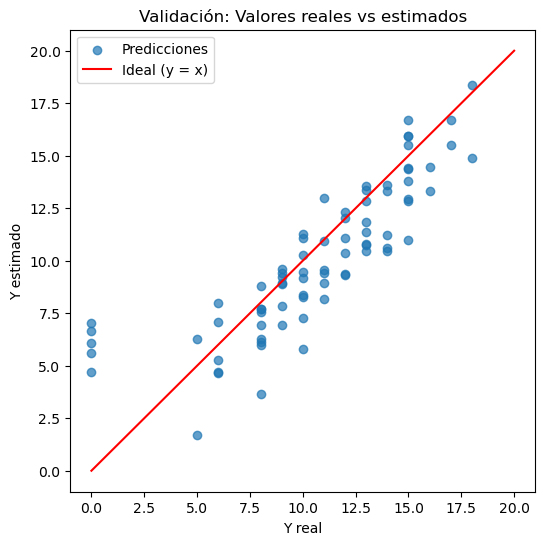


El modelo no es un modelo perfecto ya que el angulo no llega a los 45 grados. No obstante se acerca bastante teniendo un angulo de 34.73688337995982 grados. Ademas el modelo tiene una R^2 de 0.6913022947454747 el cual se acerca a 1.


In [95]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

Y_hatTest = results.predict(sm.add_constant(X_test))

plt.figure(figsize=(6,6))
plt.scatter(Y_test, Y_hatTest, alpha=0.7, label="Predicciones")
plt.plot([Y_train.min(), Y_train.max()],
         [Y_train.min(), Y_train.max()],
         color="red", label="Ideal (y = x)")
plt.xlabel("Y real")
plt.ylabel("Y estimado")
plt.title("Validación: Valores reales vs estimados")
plt.legend()
plt.show()

model = LinearRegression().fit(Y_test.values.reshape(-1, 1), Y_hatTest)
angulo_deg = np.arctan(model.coef_[0]) *180/np.pi
from sklearn.metrics import r2_score
r2 = r2_score(Y_test, Y_hatTest)
print("\nEl modelo no es un modelo perfecto ya que el angulo no llega a los 45 grados. No obstante se acerca bastante teniendo un angulo de",angulo_deg,"grados. Ademas el modelo tiene una R^2 de", r2, "el cual se acerca a 1.")